In [7]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy.optimize
import matplotlib.dates as mdates
from datetime import datetime, timedelta
pd.set_option('display.max_rows', 500)

In [13]:
confirmed_df = pd.read_csv(r'../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
confirmed_df.rename(columns={'Province/State': 'Province_State', 'Country/Region': 'Country_Region'}, inplace=True)
confirmed_df.head()

,Province_State,Country_Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,16,21,22,22,22,24,24,40,40,74
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,42,51,55,59,64,70,76,89,104,123
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,48,54,60,74,87,90,139,201,230,264
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,1,2,39,39,53,75,88,113,133,164
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,0,0,0,0,0,1,2,2,3,3


In [14]:
def create_df(a_series):
    dates = a_series.index[4:].values
    counts = a_series.values[4:]
    df = pd.DataFrame({'date': dates, 'count': counts})
    df['Province_State'] = a_series['Province_State'] 
    df['Country_Region'] = a_series['Country_Region'] 
    df['Lat'] = a_series['Lat'] 
    df['Long'] = a_series['Long'] 
    return df

In [15]:
confirmed_df_2 = pd.concat(confirmed_df.apply(create_df, axis=1).values).set_index(['Country_Region', 'Province_State', 'Lat', 'Long'])
confirmed_df_2['date'] = pd.to_datetime(confirmed_df_2['date'])
confirmed_df_2.head()

date count
Country_Region Province_State Lat  Long                 
Afghanistan    NaN            33.0 65.0 2020-01-22     0
                                   65.0 2020-01-23     0
                                   65.0 2020-01-24     0
                                   65.0 2020-01-25     0
                                   65.0 2020-01-26     0

In [16]:
a = confirmed_df_2.reset_index()
b = a.groupby(['Country_Region', 'date']).agg({'Lat': 'mean', 'Long': 'mean', 'count': 'sum'})
countries_df = b.reset_index().set_index(['Country_Region', 'Lat', 'Long'])
countries_df.tail()

date  count
Country_Region Lat   Long                  
Zimbabwe       -20.0 30.0 2020-03-20      1
                     30.0 2020-03-21      3
                     30.0 2020-03-22      3
                     30.0 2020-03-23      3
                     30.0 2020-03-24      3

In [35]:
country_df = confirmed_df_2.query('Country_Region == "Israel"')
# country_df = countries_df.query('Country_Region == "US"')
# country_df = confirmed_df_2.query('Country_Region == "Spain"')
# country_df = confirmed_df_2.query('Country_Region == "Italy"')
country_df.tail()

date count
Country_Region Province_State Lat  Long                 
Israel         NaN            31.0 35.0 2020-03-20   705
                                   35.0 2020-03-21   883
                                   35.0 2020-03-22  1071
                                   35.0 2020-03-23  1442
                                   35.0 2020-03-24  1930

In [36]:
last_date = country_df['date'].iloc[-1]
last_date

Timestamp('2020-03-24 00:00:00')

In [37]:
values = list(country_df.index[0]) + [last_date + timedelta(days=1), 945]
columns = list(country_df.index.names) + country_df.columns.tolist()
values, columns
row_df = pd.DataFrame([values], columns=columns).set_index(country_df.index.names)
row_df

,,,,date,count
Country_Region,Province_State,Lat,Long,,
Israel,NaN,31.0,35.0,2020-03-25,945


In [38]:
# country_updated_df = country_df.append(row_df)
# country_updated_df.tail()
country_updated_df = country_df

<IPython.core.display.Javascript object>


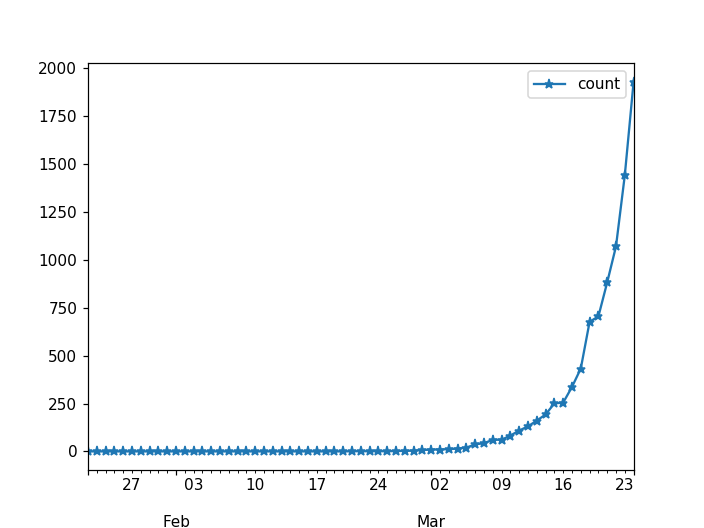

In [39]:
%matplotlib notebook
country_updated_df.plot(x='date', y='count', marker='*')

In [22]:
def exponential(x, a, k, b):
    return a*np.exp(x*k) + b

In [40]:
non_zero_country_df = country_updated_df[country_updated_df['count'] > 0]
y_array_exp = non_zero_country_df['count'].values
ref_date = datetime(2020, 1, 1)
x_array = (non_zero_country_df['date'] - ref_date).dt.days.values.astype(float)

In [41]:
last_model_date = country_updated_df['date'].iloc[-1]
# last_model_date = datetime(2020, 3, 18)
last_model_index = np.argmin((non_zero_country_df['date'] - last_model_date).abs().values)
last_model_index

32

In [42]:
popt_exponential, pcov_exponential = scipy.optimize.curve_fit(exponential, x_array[:last_model_index], y_array_exp[:last_model_index], p0=
(0.0021819439144763727, 0.2196989290489097, -0.8576298838011189))
a, k, b = popt_exponential
a, k, b, np.exp(k), np.exp(k*7)

(1.5083482386065054e-05,
 0.22378103609203492,
 0.5282886324569118,
 1.2507971100180382,
 4.789697479004134)

In [43]:
estimated = exponential(x_array, a, k, b)
non_zero_country_df['estimated'] = estimated
estimated

/home/erez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


array([   1.89297215,    2.23523083,    2.663327  ,    3.19878846,
          3.86854209,    4.70626801,    5.75409316,    7.06470983,
          8.70402538,   10.75447653,   13.3191749 ,   16.52709221,
         20.53954591,   25.55831141,   31.83576878,   39.68759432,
         49.50863502,   61.79276435,   77.1577178 ,   96.37615718,
        120.41452561,  150.48164738,  188.08951639,  235.12933026,
        293.96659351,  367.56007234,  459.61058298,  574.74709566,
        718.75951298,  898.88982837, 1124.19630629, 1406.00899773,
       1758.49949776])

<IPython.core.display.Javascript object>


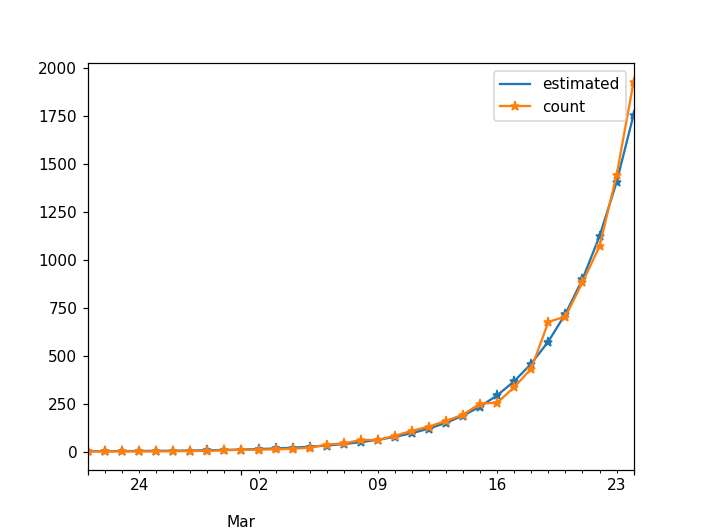

In [44]:
plt.figure()
ax = plt.gca()
non_zero_country_df.plot(ax=ax, x='date', y='estimated' ,marker='*')
non_zero_country_df.plot(ax=ax, x='date', y='count' ,marker='*')
plt.show()

In [28]:
non_zero_country_df

date  count     estimated
Country_Region Lat     Long                                    
US             37.0902 -95.7129 2020-01-22      1     -8.108310
                       -95.7129 2020-01-23      1     -8.108178
                       -95.7129 2020-01-24      2     -8.107998
                       -95.7129 2020-01-25      2     -8.107753
                       -95.7129 2020-01-26      5     -8.107422
                       -95.7129 2020-01-27      5     -8.106972
                       -95.7129 2020-01-28      5     -8.106362
                       -95.7129 2020-01-29      5     -8.105535
                       -95.7129 2020-01-30      5     -8.104412
                       -95.7129 2020-01-31      7     -8.102889
                       -95.7129 2020-02-01      8     -8.100823
                       -95.7129 2020-02-02      8     -8.098021
                       -95.7129 2020-02-03     11     -8.094219
                       -95.7129 2020-02-04     11     -8.089061
                       -95.7129 2020-02-05     11     -8.082064
                       -95.7129 2020-02-06     11     -8.072571
                       -95.7129 2020-02-07     11     -8.059694
                       -95.7129 2020-02-08     11     -8.042224
                       -95.7129 2020-02-09     11     -8.018525
                       -95.7129 2020-02-10     11     -7.986374
                       -95.7129 2020-02-11     12     -7.942759
                       -95.7129 2020-02-12     12     -7.883589
                       -95.7129 2020-02-13     13     -7.803320
                       -95.7129 2020-02-14     13     -7.694427
                       -95.7129 2020-02-15     13     -7.546702
                       -95.7129 2020-02-16     13     -7.346298
                       -95.7129 2020-02-17     13     -7.074429
                       -95.7129 2020-02-18     13     -6.705610
                       -95.7129 2020-02-19     13     -6.205270
                       -95.7129 2020-02-20     13     -5.526506
                       -95.7129 2020-02-21     15     -4.605693
                       -95.7129 2020-02-22     15     -3.356514
                       -95.7129 2020-02-23     15     -1.661874
                       -95.7129 2020-02-24     51      0.637080
                       -95.7129 2020-02-25     51      3.755850
                       -95.7129 2020-02-26     57      7.986784
                       -95.7129 2020-02-27     58     13.726484
                       -95.7129 2020-02-28     60     21.512981
                       -95.7129 2020-02-29     68     32.076171
                       -95.7129 2020-03-01     74     46.406230
                       -95.7129 2020-03-02     98     65.846439
                       -95.7129 2020-03-03    118     92.219095
                       -95.7129 2020-03-04    149    127.996332
                       -95.7129 2020-03-05    217    176.531857
                       -95.7129 2020-03-06    262    242.375321
                       -95.7129 2020-03-07    402    331.698795
                       -95.7129 2020-03-08    518    452.875333
                       -95.7129 2020-03-09    583    617.263849
                       -95.7129 2020-03-10    959    840.273886
                       -95.7129 2020-03-11   1281   1142.810084
                       -95.7129 2020-03-12   1663   1553.231751
                       -95.7129 2020-03-13   2179   2110.011223
                       -95.7129 2020-03-14   2727   2865.340207
                       -95.7129 2020-03-15   3499   3890.022154
                       -95.7129 2020-03-16   4632   5280.109276
                       -95.7129 2020-03-17   6421   7165.906339
                       -95.7129 2020-03-18   7783   9724.185246
                       -95.7129 2020-03-19  13677  13194.755379
                       -95.7129 2020-03-20  19100  17902.942989
                       -95.7129 2020-03-21  25489  24290.086805
                       -95.7129 2020-03-22  33276  32954.908497
      

In [29]:
extrapolation_dates_series = pd.Series([last_model_date + timedelta(days=k) for k in range(1, 7)])
extrapolation_x_array = (extrapolation_dates_series - ref_date).dt.days.values.astype(float)
extrapolation_estimated = exponential(extrapolation_x_array, a, k, b)
extrapolation_df = pd.DataFrame({'date': extrapolation_dates_series, 'estimated': extrapolation_estimated})
extrapolation_df

,date,estimated
0,2020-03-25,82289.224419
1,2020-03-26,111636.741910
2,2020-03-27,151449.687022
3,2020-03-28,205460.067931
4,2020-03-29,278730.740015
5,2020-03-30,378129.990627


<IPython.core.display.Javascript object>


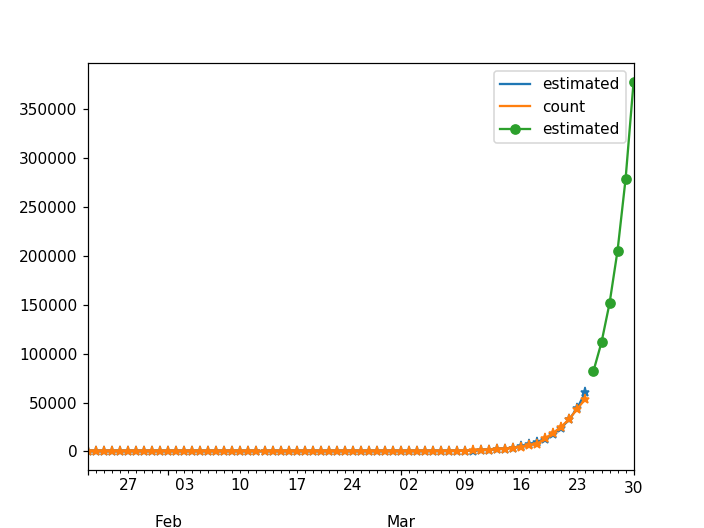

In [30]:
plt.figure()
ax = plt.gca()
non_zero_country_df.plot(ax=ax, x='date', y='estimated' ,marker='*')
non_zero_country_df.plot(ax=ax, x='date', y='count' ,marker='*')
extrapolation_df.plot(ax=ax, x='date', y='estimated' ,marker='o')
plt.show()

In [31]:
# %matplotlib notebook
# plt.figure(figsize=(9, 8))
# for iteration in range(0, 8):
#     plt.subplot(331 + iteration)
#     n_days = int(iteration * 7)
#     x_long_term = range(len(y_array_exp) + n_days)
#     y_forecast = exponential(x_long_term, a, k, b)
#     max_val = y_forecast.max() 
#     plt.plot(estimated)
#     plt.plot(y_array_exp, '--*')
#     plt.plot(y_forecast, '--b')
#     plt.title(f'weeks from now: {iteration}\ncases:{int(max_val):,}', y=.5)

# countries growth per week

In [32]:
def get_growth_rate(df):
    try:
        non_zero_country_df = df[df['count'] > 0]
        y_array_exp = non_zero_country_df['count'].values
        ref_date = datetime(2020, 1, 1)
        x_array = (non_zero_country_df['date'] - ref_date).dt.days.values.astype(float)
        popt_exponential, pcov_exponential = scipy.optimize.curve_fit(exponential, x_array[:last_model_index], y_array_exp[:last_model_index], p0=
        (0.0021819439144763727, 0.2196989290489097, -0.8576298838011189))
        a, k, b = popt_exponential
        estimated = exponential(x_array, a, k, b)
        max_error_in_percentage = np.abs(estimated - y_array_exp).max() / y_array_exp.max() * 100
        return_values = [np.exp(k), np.exp(k*7), max_error_in_percentage, y_array_exp.max()]        
    except:
        return_values = [None, None, None, None]
    names = ['day_rate', 'week_rate', 'max_error_in_percentage', 'confirmed_cases']
    return pd.Series(return_values, index=names)

In [33]:
countries_stat_df = countries_df.groupby('Country_Region').apply(get_growth_rate)
countries_stat_df

/home/erez/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


,day_rate,week_rate,max_error_in_percentage,confirmed_cases
Country_Region,,,,
Afghanistan,1.225006,4.139692,1.665193e+01,74.0
Albania,1.060294,1.506555,7.415632e+00,123.0
Algeria,1.247786,4.709568,9.693385e+00,264.0
Andorra,1.264286,5.163176,1.205947e+01,164.0
Angola,NaN,NaN,NaN,NaN
Antigua and Barbuda,NaN,NaN,NaN,NaN
Argentina,1.303186,6.383291,8.691766e+00,387.0
Armenia,1.197355,3.528260,9.100316e+00,249.0
Australia,1.246273,4.669724,9.345163e+00,2044.0


In [34]:
countries_stat_sorted_df = countries_stat_df.dropna().round(4).sort_values(by='confirmed_cases', ascending=False)
countries_stat_sorted_df

,day_rate,week_rate,max_error_in_percentage,confirmed_cases
Country_Region,,,,
Italy,1.1348,2.4242,7.4367,69176.0
US,1.3566,8.4561,12.8696,53740.0
Spain,1.2014,3.6121,5.0836,39885.0
Germany,1.2000,3.5834,9.0804,32986.0
Iran,1.0601,1.5043,6.4939,24811.0
France,1.1796,3.1775,3.5750,22622.0
Switzerland,1.1963,3.5069,5.9485,9877.0
"Korea, South",1.0370,1.2895,26.2667,9037.0
United Kingdom,1.2239,4.1133,6.1627,8164.0


In [ ]:
# countries_stat_sorted_df.to_excel('countries_stat.xlsx')